author: Tri Doan   
Last modified: April 2019   

This prototype illustrates hot to implement time cohort analytics on online data. This illustration purpose, we use a subset of online dataset.

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

# Load Online Retail dataset
The original dataset can be found here - http://archive.ics.uci.edu/ml/datasets/online+retail
Its outliers and missing data are processed as `OnlineClean.xlsx` 

In [3]:
os.chdir("C:/Projects_prototype/cohort_analysis")
# Pre-processed file
online = pd.read_excel('OnlineClean.xlsx')

# Further cleaned file: UK-only, randomly sampled 20% of the data
# online = pd.read_excel('OnlineSampled.xlsx')

In [6]:
online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
InvoiceNo      397884 non-null int64
StockCode      397884 non-null object
Description    397884 non-null object
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null int64
Country        397884 non-null object
TotalSum       397884 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 30.4+ MB


##  Time-based cohorts 

Time-based cohorts is created that associated the acquisition month to each customer i.e. the month when each customer made their first paid transaction with the company.

The following calculate several metrics will be calculated :
 - retention
 - average quantity
 - average price
 - average total basket sum

In [5]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


### transform numeric customer id into strings for later aggregation task

In [9]:
online['CustomerID'] = online['CustomerID'].astype(str)
# How many unique customers?
len(set(online['CustomerID']))

4338

### Create an "InvoiceMonth" column
This column will be later used for defining the acquisition month for each customer

In [11]:
online['InvoiceMonth'] = online['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, 1))

### Assign acquisition month cohort per customer
We're going to use **transform** function on the dataframe to calculate the first month of each customer's purchase that will define their month of acquisition.

In [12]:
online['CohortMonth'] = online.groupby('CustomerID')['InvoiceMonth'].transform('min')

### Calculate cohort index - ***nth*** month offset
Cohort index will allow us to normalize the metrics and compare them for each monthly cohort. This way we can assess the performance of each monthly cohort for a given ***nth*** month after customer's acquisition.


In [13]:
online['CohortIndex'] = (
    online['InvoiceMonth'].apply(lambda x: x.year) - online['CohortMonth'].apply(lambda x: x.year))*12 + \
    (online['InvoiceMonth'].apply(lambda x: x.month) - online['CohortMonth'].apply(lambda x: x.month)) + 1

### Creating a string cohort month value
We will use this column to create a retention heatmap, and it will look much more beautiful in a short year-month format, than a full timestamp.

In [14]:
online['CohortMonth'] = online['CohortMonth'].apply(lambda x: x.strftime('%Y-%m'))

In [15]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12,1


### Create cohorts dataset with raw metrics
This is a fundamental step where metrics are defined. In this case we are creating three metrics: customer count, average price, and average quantity. We are going to use only the first one - customer count - to measure retention rate.

In [16]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping.agg({'CustomerID': pd.Series.nunique,
                           'UnitPrice': np.mean,
                           'Quantity': np.mean,
                           'TotalSum': np.mean})

cohort_data.rename(columns = {'CustomerID': 'CustomerCount',
                           'UnitPrice': 'AveragePrice',
                           'Quantity': 'AverageQuantity',
                           'TotalSum': 'AverageTotalSum'}, inplace = True)

### Create a pivot table with active purchasers from each cohort
We will create a pivot table with ***CohortMonth*** in rows, and ***CohortIndex*** in columns, with ***CustomerCount*** as the values. 

In [17]:
cohort_data.reset_index(level=['CohortMonth', 'CohortIndex'], inplace=True)
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerCount')

In [18]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate retention rates
First, we're going to extract cohort size on the first month of their tenure with the company. Next, we will divide the number of active purchasers from each cohort by the size of that cohort. The result is a retention metric per each monthly cohort. 

In [19]:
cohort_sizes = cohort_counts[1].values
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [20]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot retention heatmap
We will use **Seaborn** library which we have imported earlier to build an easy-to-read heatmap chart.

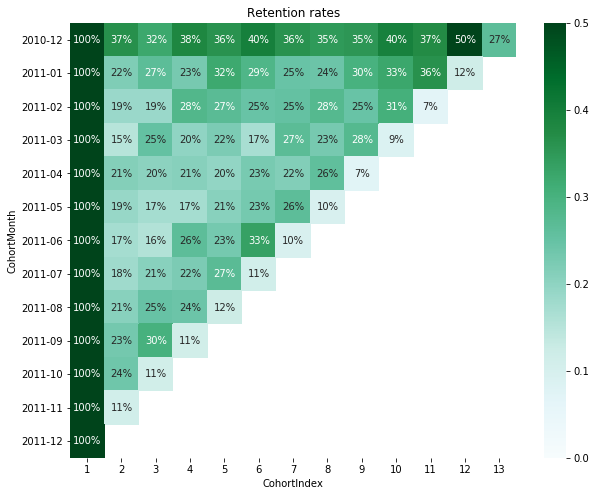

In [21]:
import seaborn as sns

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuGn')
plt.show()

### Calculate average monthly spend per cohort and plot a heatmap

In [22]:
cohort_totalsum = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='AverageTotalSum')
cohort_totalsum

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,21.895244,27.114025,26.642973,26.903292,21.012301,27.924305,28.072792,27.194953,29.072756,33.224203,33.671511,23.267983,25.613886
2011-01,26.556231,24.842302,20.818746,30.936646,22.370130,26.081955,25.101110,25.239483,18.993579,22.113113,19.368684,19.303297,NaN
2011-02,17.709078,20.568867,21.269069,19.264720,17.624192,16.892019,22.111490,22.792274,18.577679,21.999134,23.503814,NaN,NaN
2011-03,17.462683,21.035290,22.636071,17.959987,21.127742,18.922369,21.917451,19.844635,16.600473,12.919699,NaN,NaN,NaN
2011-04,16.859402,20.962861,19.484903,18.686756,19.291928,14.821541,15.057237,15.658102,12.141683,NaN,NaN,NaN,NaN
2011-05,20.275083,17.140147,22.045590,20.896587,18.463797,13.996859,16.824702,226.613818,NaN,NaN,NaN,NaN,NaN
2011-06,23.764522,16.022890,19.825490,20.262821,15.184188,16.452056,13.121770,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,14.825471,23.532275,11.653548,12.830022,10.756400,11.544030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,16.420856,13.101831,12.461881,15.885078,17.001513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


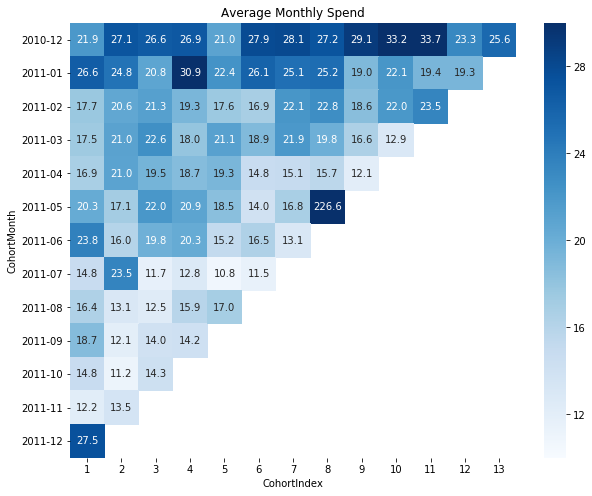

In [23]:
plt.figure(figsize=(10, 8))
plt.title('Average Monthly Spend')
sns.heatmap(cohort_totalsum, annot=True, fmt='.1f', vmin=10, vmax = 30, cmap='Blues')
plt.show()

# 2. Building size-based cohorts

Here we are going to build cohorts based on size of their transactions on the first month, and convert them into quirtiles and other percentiles that will define their cohorts.

We will calculate these size-based cohorts:

     TotalSum quartiles
     TotalSum deciles

###  a. TotalSum quartiles

We need to extract first offset month (`CohortIndex == 1`) of the customer, and group them into quartiles based on `TotalSum` value

In [24]:
online_first_totalsum = online[online['CohortIndex'] == 1].groupby(['CustomerID'])['TotalSum'].agg('sum').reset_index()
online_first_totalsum.head(10)

,CustomerID,TotalSum
0,12346,77183.60
1,12347,711.79
2,12348,892.80
3,12349,1757.55
4,12350,334.40
5,12352,296.50
6,12353,89.00
7,12354,1079.40
8,12355,459.40
9,12356,2271.62


### Assign quartile values based on `TotalSum`

Our solution is split data into subgroup with quantile strategy. The quartile with the highest value for `TotalSum` is assigned a quartile label of `1` and the lowest one receives `4`. These will be our next features

In [25]:
online_first_totalsum['TotalSum_quartile'] = (pd.qcut(
    online_first_totalsum['TotalSum'], 4, labels = list(reversed(range(1,5)))))
online = online.merge(online_first_totalsum[['CustomerID', 'TotalSum_quartile']], on='CustomerID', how='left')

### Create cohorts dataset with raw metrics

In the next steps we repeat the steps outlined above.

In [26]:
grouping = online.groupby(['TotalSum_quartile', 'CohortIndex'])

cohort_data = grouping.agg({'CustomerID': pd.Series.nunique,
                           'UnitPrice': np.mean,
                           'Quantity': np.mean,
                           'TotalSum': np.mean})

cohort_data.rename(columns = {'CustomerID': 'CustomerCount',
                           'UnitPrice': 'AveragePrice',
                           'Quantity': 'AverageQuantity',
                           'TotalSum': 'AverageTotalSum'}, inplace = True)

In [27]:
cohort_data[:10]

CustomerCount  AveragePrice  AverageQuantity  \
TotalSum_quartile CohortIndex                                                 
4                 1                     1085      2.902815         6.453855   
                  2                      166      3.631685         6.879544   
                  3                      138      4.106170         7.281783   
                  4                      148      4.610120         7.980922   
                  5                      167      3.541558         7.250809   
                  6                      141      2.764407         8.762446   
                  7                      131      2.607901         8.209853   
                  8                      106      2.793163        40.011714   
                  9                      106      2.416729        15.720465   
                  10                     118      2.620533         8.672846   

                               AverageTotalSum  
TotalSum_quartile CohortIndex                   
4                 1                   9.990071  
                  2                  13.597914  
                  3                  13.491189  
                  4                  16.682339  
                  5                  12.885357  
                  6                  12.331427  
                  7                  11.847599  
                  8                  78.990797  
                  9                  24.313719  
                  10                 14.986589

In [28]:
cohort_counts = cohort_data.reset_index().pivot(index='TotalSum_quartile', columns='CohortIndex', values='CustomerCount')
cohort_sizes = cohort_counts[1].values
retention = cohort_counts.divide(cohort_sizes, axis=0)

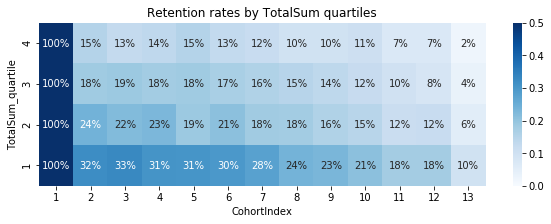

In [29]:
import seaborn as sns

plt.figure(figsize=(10, 3))
plt.title('Retention rates by TotalSum quartiles')
sns.heatmap(retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='Blues')
plt.show()

### b. TotalSum deciles

We need to extract first offset month (`CohortIndex == 1`) of the customer, and group them into deciles based on `TotalSum` value.

Same like with the quartiles above, we calculate the decile labels and merge it back to the `online` dataset. Then we aggregate the metrics on these values, and build a heatmap.

In [30]:
online_first_totalsum['TotalSum_decile'] = (pd.qcut(
    online_first_totalsum['TotalSum'], 10, labels = list(reversed(range(1,11)))))
online = online.merge(online_first_totalsum[['CustomerID', 'TotalSum_decile']], on='CustomerID', how='left')

In [31]:
grouping = online.groupby(['TotalSum_decile', 'CohortIndex'])

cohort_data = grouping.agg({'CustomerID': pd.Series.nunique,
                           'UnitPrice': np.mean,
                           'Quantity': np.mean,
                           'TotalSum': np.mean})

cohort_data.rename(columns = {'CustomerID': 'CustomerCount',
                           'UnitPrice': 'AveragePrice',
                           'Quantity': 'AverageQuantity',
                           'TotalSum': 'AverageTotalSum'}, inplace = True)

In [32]:
cohort_data.reset_index(level=['TotalSum_decile', 'CohortIndex'], inplace=True)
cohort_counts = cohort_data.pivot(index='TotalSum_decile', columns='CohortIndex', values='CustomerCount')
cohort_sizes = cohort_counts[1].values
retention = cohort_counts.divide(cohort_sizes, axis=0)

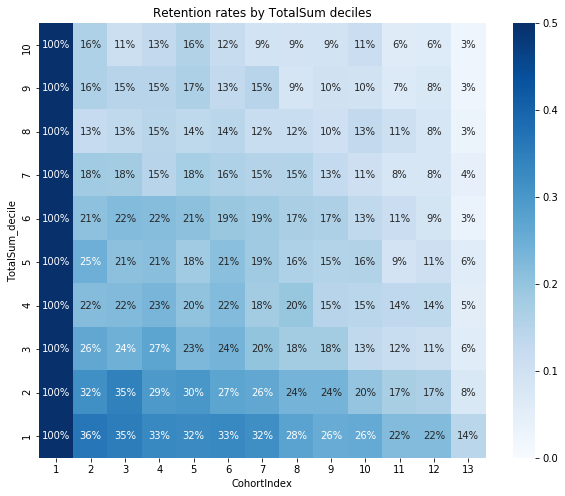

In [33]:
plt.figure(figsize=(10, 8))
plt.title('Retention rates by TotalSum deciles')
sns.heatmap(retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='Blues')
plt.show()